In [41]:
import pandas as pd
import numpy as np
from itertools import groupby
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import cluster,mixture
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeCV, LassoCV
import scipy
import math
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn import linear_model

import sys
# import mss
sys.path.append('../')
from mss import visreader as mvis
from mss import mssmain as msm
from mss import align
from mss import dm

/home/hack_summer/miniconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.

/home/hack_summer/miniconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.



In [2]:
df = pd.read_csv('../example_data/clustering/testdata_1114_patternrec.csv')

In [21]:
source_col = df.columns[df.columns.str.contains('dil-to')]
dfp = df[source_col].copy()
dfp.shape

(5299, 36)

In [87]:
mean_list = []
for i in list(set([i[:-2] for i in df.iloc[:,5:].columns])):
    mean_list.append(list(df.iloc[:,5:][df.iloc[:,5:].columns[df.iloc[:,5:].columns.str.contains(i)]].mean(1)))

In [88]:
df_m = pd.DataFrame(mean_list).T
df_m.columns = list(set([i[:-2] for i in df.iloc[:,5:].columns]))
df_m.head()

,20181114_SR520-Creek_Mix4A,20181114_SR520-Cal-in-DI_1000mL_dil-to-10mL,20181114_CoulterCreek,20181114_MSMS_Miller-Creek-20181025_Site5down-HLB,20181114_MSMS_Miller-Creek-20181025_Site8MW-HLB,20181114_SR518-Cal_1000mL_dil-to-25mL,20181114_SR520-Cal-in-DI_1000mL_dil-to-60mL,20181114_SR518-Cal_1000mL_dil-to-400mL,20181114_SR520-Cal-in-DI_1000mL_dil-to-25mL,20181114_SR518-Cal_1000mL_dil-to-60mL,...,20181114_SwanCreek-Dec,20181114_SR520-Cal-in-DI_400mL,20181114_MSMS_Miller-Creek-20181025_Site4-HLB,20181114_SR520-Cal-in-DI_1000mL_dil-to-1mL,20181114_SR520-Cal-in-DI_1000mL_dil-to-160mL,20181114_Crescent-Creek-May,20181114_SR520-Cal-in-DI_1000mL_dil-to-400mL,20181114_SR520-Cal-in-DI_25mL,20181114_SR520-Cal-in-DI_1000mL,20181114_SR520-Cal-in-DI_1mL
0,11058.666667,2201.333333,3204.000000,74715.0,39193.0,4968.333333,12058.000000,46733.000000,6149.333333,11792.333333,...,5038.666667,51588.333333,14036.0,346.666667,28334.333333,3607.666667,57931.333333,9069.000000,27219.904762,2727.333333
1,4189.666667,934.666667,2505.000000,146454.0,189119.0,2471.666667,2774.333333,25538.333333,1530.333333,3319.000000,...,1676.666667,15910.000000,153779.0,1029.666667,9873.000000,3752.666667,16742.000000,2038.333333,10014.333333,1429.333333
2,5127.333333,1441.666667,2379.000000,175420.0,189706.0,4827.333333,5605.666667,62643.666667,2612.333333,11075.000000,...,1501.333333,36139.000000,147749.0,1970.666667,21364.333333,3262.333333,39520.333333,3245.666667,20995.619048,1685.666667
3,97944.000000,22868.333333,568.666667,87411.0,137532.0,8532.333333,137878.666667,88178.666667,55173.666667,18243.000000,...,1283.666667,873611.000000,40774.0,2679.000000,325304.333333,1138.666667,710576.333333,84524.666667,358528.095238,2901.000000
4,1895.000000,700.000000,0.000000,34312.0,17085.0,657.000000,4073.000000,14439.666667,2116.666667,3149.000000,...,181.666667,11485.000000,0.0,0.000000,11652.666667,128.333333,21355.333333,1292.000000,9811.190476,169.000000


In [25]:
mean_list = []
for i in list(set([i[:-2] for i in source_col])):
    mean_list.append(list(dfp[dfp.columns[dfp.columns.str.contains(i)]].mean(1)))

In [35]:
df_mean = pd.DataFrame(mean_list).T
df_mean.columns = list(set([i[:-2] for i in source_col]))
d_clu = df_mean[df_mean.columns[df_mean.columns.str.contains('520')]].copy()

In [39]:
c_data = d_clu.values
c_norm = [((row-np.mean(row))/np.std(row)) for row in c_data]
#Clean up dataframe
c_norm = np.asarray(c_norm)
d_norm = pd.DataFrame(c_norm)
d_norm['index']=d_clu.index
d_norm.set_index('index',inplace=True)
d_norm.dropna(how='all',inplace=True)
d_norm.columns = d_clu.columns

<ipython-input-39-65655e08fa95>:2: RuntimeWarning: invalid value encountered in true_divide
  c_norm = [((row-np.mean(row))/np.std(row)) for row in c_data]


eps selected 0.9590720349692694


array([0.        , 0.        , 0.        , ..., 1.27108023, 1.27154856,
       1.42381247])

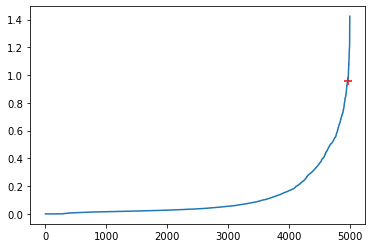

In [42]:
dm.eps_assess(d_norm, 12)

In [48]:
d_norm.columns

Index(['20181114_SR520-Cal-in-DI_1000mL_dil-to-25mL',
       '20181114_SR520-Cal-in-DI_1000mL_dil-to-10mL',
       '20181114_SR520-Cal-in-DI_1000mL_dil-to-60mL',
       '20181114_SR520-Cal-in-DI_1000mL_dil-to-160mL',
       '20181114_SR520-Cal-in-DI_1000mL_dil-to-400mL',
       '20181114_SR520-Cal-in-DI_1000mL_dil-to-1mL'],
      dtype='object')

/home/hack_summer/miniconda3/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



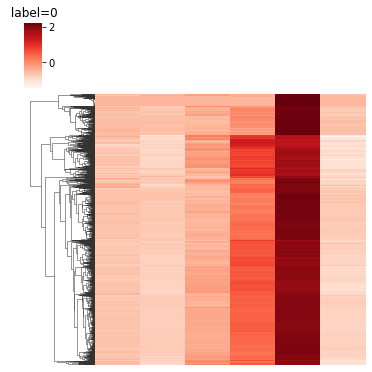

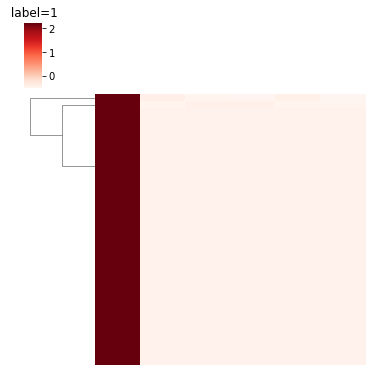

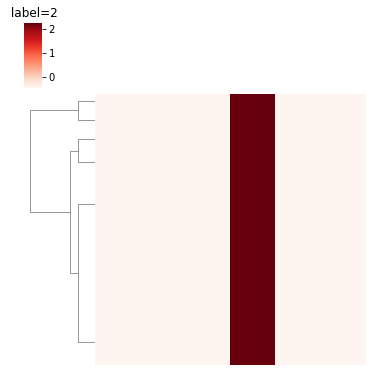

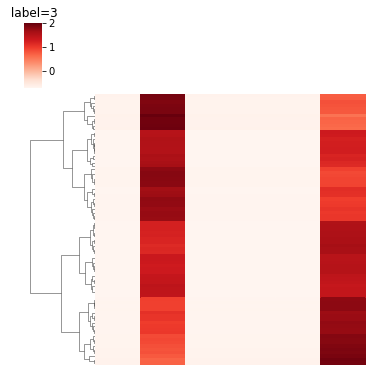

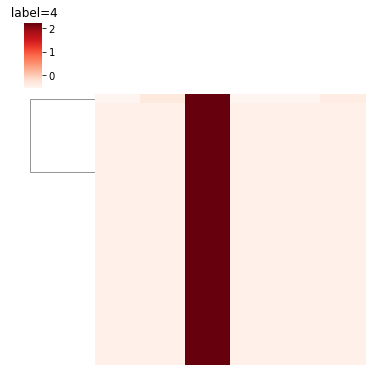

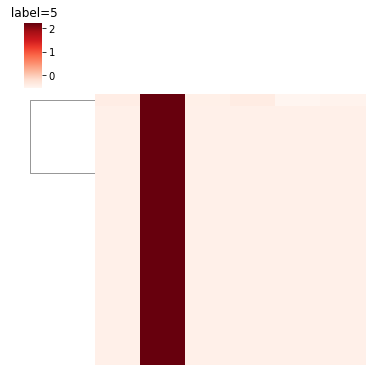

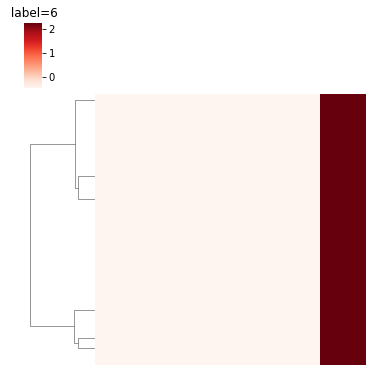

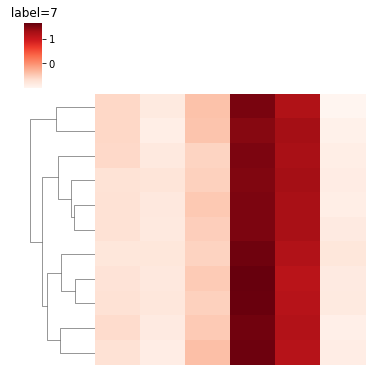

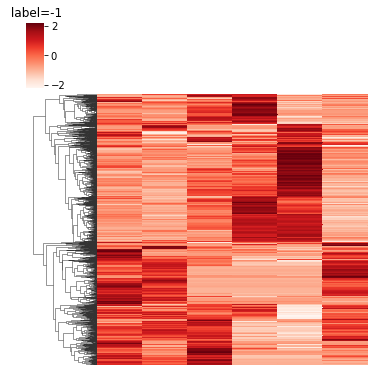

In [75]:
dbscan = cluster.DBSCAN(eps=0.2, min_samples=12).fit(d_norm)
labels = dbscan.labels_
unique_labels = set(dbscan.labels_)

for i,k in enumerate(unique_labels):
    indexlist = list(np.argwhere(labels==k).reshape(1,-1)[0])
    sns.clustermap(d_norm.iloc[indexlist].values,cmap='Reds',col_cluster=False,yticklabels=False,xticklabels=False,figsize=(5,5))
    plt.title(' label='+ str(k))
    plt.show()
    
d_init = d_clu.copy()
d_label = d_clu.loc[d_norm.index] #Use the index to match back to the original datasheet
d_label.insert(len(d_clu.columns),"label", dbscan.labels_.tolist())

In [76]:
d_source = df.loc[d_label[d_label['label'] == 0].index].copy()
d_bg = df.loc[d_label[d_label['label'] != 0].index].copy()

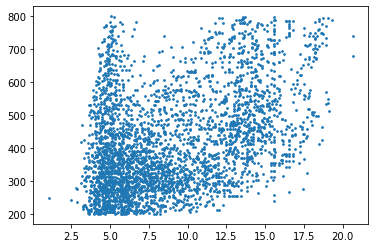

In [83]:
plt.scatter(d_source['Average RT (min)'], d_source['Average m/z'],s=3)
#plt.scatter(d_bg['Average RT (min)'], d_bg['Average m/z'],s=3,alpha=0.5)

In [158]:
df_m.columns

Index(['20181114_SR520-Creek_Mix4A',
       '20181114_SR520-Cal-in-DI_1000mL_dil-to-10mL', '20181114_CoulterCreek',
       '20181114_MSMS_Miller-Creek-20181025_Site5down-HLB',
       '20181114_MSMS_Miller-Creek-20181025_Site8MW-HLB',
       '20181114_SR518-Cal_1000mL_dil-to-25mL',
       '20181114_SR520-Cal-in-DI_1000mL_dil-to-60mL',
       '20181114_SR518-Cal_1000mL_dil-to-400mL',
       '20181114_SR520-Cal-in-DI_1000mL_dil-to-25mL',
       '20181114_SR518-Cal_1000mL_dil-to-60mL', '20181114_SR518-Cal_1000mL',
       '20181114_SR520-Cal-in-DI_10mL', '20181114_SR520-Creek_Mix5A',
       '20181114_SR520-Creek_Mix1', '20181114_SR520-Creek_Mix5B',
       '20181114_SR518-Cal_1000mL_dil-to-1mL', '20181114_SR520-Cal-in-DI_60mL',
       '20181114_SR520-Creek_Mix3', '20181114_SR518-Cal_1000mL_dil-to-10mL',
       '20181114_SR518-Cal_1000mL_dil-to-160mL', '20181114_SR520-Creek_Mix6A',
       '20181114_RuralCreek', '20181114_SR520-Creek_Mix2',
       '20181114_SwanCreek-May', '20181114_Crescent-C

In [161]:
#select comparison sample
source_col = '20181114_SR520-Cal-in-DI_400mL'
sample_col ='20181114_SwanCreek-Dec'

d_index = df_m.index[df_m[sample_col] >= 2000]
source_index = d_source.index
print('simple source prediction score: ', len([i for i in source_index if i in d_index])/len(source_index))

#MSDIAL algorithm, if 2d only consider mz/rt, 3d (plus intensity) need to alter their equations
#Maybe not accurate
union_index = list(set(source_index).union(set(d_index)))
intersec_index = [i for i in source_index if i in d_index]

sl = df_m[source_col]
union_b = np.asarray(df_m.iloc[union_index,0])
intersec_b = np.asarray(df_m.iloc[intersec_index,0])
union_s = np.asarray([sl[i] for i in union_index])
intersec_s = np.asarray([sl[i] for i in intersec_index])
#Normalize?
print('msdial algorithm score:', (np.dot(union_b,union_s)
 /(np.linalg.norm(union_b)
   *np.linalg.norm(union_s)))
/(np.dot(intersec_b,intersec_s)
  /(np.linalg.norm(intersec_b)
    *np.linalg.norm(intersec_s))))

simple source prediction score:  0.33224852071005917
msdial algorithm score: 0.9951044762930272


In [149]:
np.linalg.norm(np.array([2,2,2,2,2,2]))

4.898979485566356

In [150]:
(np.dot(union_b,union_s)/(np.linalg.norm(union_b)*np.linalg.norm(union_s)))/(np.dot(intersec_b,intersec_s)/(np.linalg.norm(intersec_b)*np.linalg.norm(intersec_s)))

0.9992621378893152